In [5]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import spearmanr
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.colors as mcolors

from bin import utils

In [6]:
apoptosis_marker = ["Add1", "Aifm3", "Ank", "Anxa1", "App", "Atf3", "Avpr1a",
                    "Bax", "Bcap31", "Bcl10", "Bcl2l1", "Bcl2l10", "Bcl2l11",
                    "Bcl2l2", "Bgn", "Bid", "Bik", "Birc3", "Bmf", "Bmp2","Bnip3l",
                    "Brca1", "Btg2", "Btg3", "Casp1", "Casp2", "Casp3", "Casp4",
                    "Casp6", "Casp7", "Casp8", "Casp9", "Cav1", "Ccna1", "Ccnd1",
                    "Ccnd2", "Cd14", "Cd2", "Cd38", "Cd44", "Cd69", "Cdc25b",
                    "Cdk2", "Cdkn1a", "Cdkn1b", "Cflar", "Clu", "Crebbp", "Cth",
                    "Ctnnb1", "Cyld", "Dap", "Dap3", "Dcn", "Ddit3", "Dffa",
                    "Diablo", "Dnaja1", "Dnajc3", "Dnm1l", "Dpyd", "Ebp", "Egr3",
                    "Emp1", "Eno2", "Erbb2", "Erbb3", "Ereg", "Etf1", "F2", "F2r",
                    "Fas", "Fasl", "Fdxr", "Fez1", "Gadd45a", "Gadd45b", "Gch1",
                    "Gna15", "Gpx1", "Gpx3", "Gpx4", "Gsn", "Gsr", "Gstm2", "Gucy2e",
                    "H1f0", "Hgf", "Hmgb2", "Hmox1", "Hspb1", "Ier3", "Ifitm3",
                    "Ifnb1", "Ifngr1", "Igf2r", "Igfbp6", "Il18", "Il1a", "Il1b",
                    "Il6", "Irf1", "Isg20", "Jun", "Krt18", "Lef1", "Lgals3",
                    "Lmna", "Lum", "Madd", "Mcl1", "Mgmt", "Mmp2", "Nedd9", "Nefh",
                    "Pak1", "Pdcd4", "Pdgfrb", "Pea15a", "Plat", "Plcb2", "Plppr4",
                    "Pmaip1", "Ppp2r5b", "Ppp3r1", "Ppt1", "Prf1", "Psen1", "Psen2",
                    "Ptk2", "Rara", "Rela", "Retsat", "Rhob", "Rhot2", "Rnasel",
                    "Rock1", "Sat1", "Satb1", "Sc5d", "Slc20a1", "Smad7", "Sod1",
                    "Sod2", "Sptan1", "Sqstm1", "Tap1", "Tgfb2", "Tgfbr3", "Timp1",
                    "Timp2", "Timp3", "Tnf", "Tnfrsf12a", "Tnfsf10", "Top2a", "Tspo",
                    "Txnip", "Vdac2", "Wee1", "Xiap"]

In [7]:
fdata = ad.read_h5ad("./RNA/Multitime.clustered.h5")
cdata = ad.read_h5ad("./RNA/Multitime.guide.h5")

In [8]:
fdata_bin20 = ad.read_h5ad("./RNA/Multitime.annotation.sort.h5")

In [9]:
sc.tl.score_genes(fdata, gene_list=apoptosis_marker, score_name="apoptosis_score")

In [10]:
available_marker = np.intersect1d(apoptosis_marker, fdata.var_names.tolist())
fdata.obs["apoptosis_score"] = fdata[:, available_marker].X.sum(axis=1)

In [11]:
fdata.obs

marker  n_genes  n_counts  _scvi_batch  _scvi_labels  \
12199      1-1     2001      5878            0             0   
1102       1-1     2264      6028            0             0   
15850      1-1     3547     12806            0             0   
16761      1-1     2619      7236            0             0   
565        1-1     2079      4818            0             0   
...        ...      ...       ...          ...           ...   
2860-5     3-2        3         3            5             0   
75-3       3-2        3         3            5             0   
10270-4    3-2        3         3            5             0   
17940-4    3-2        6        15            5             0   
3900-4     3-2        3         4            5             0   

        cluster_cellcharter_givenk  apoptosis_score  
12199                            9        30.534026  
1102                             5        30.825903  
15850                           10        33.694940  
16761                            9        32.144886  
565                              1        35.472949  
...                            ...              ...  
2860-5                           5         0.000000  
75-3                            10         0.000000  
10270-4                         10         0.000000  
17940-4                          5         0.000000  
3900-4                           5         0.000000  

[118279 rows x 7 columns]

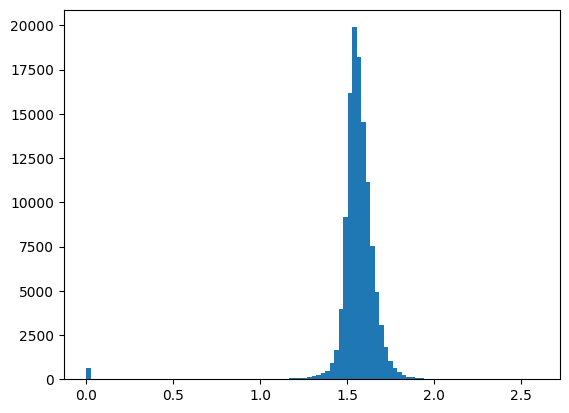

In [12]:
plt.hist(np.log10(fdata.obs["apoptosis_score"] + 1), bins=100)
plt.show()

In [13]:
u = np.mean(fdata.obs["apoptosis_score"])
d = np.std(fdata.obs["apoptosis_score"])
print(u - 3 * d, u + 3 * d)

11.202727085825654 61.830901918566056


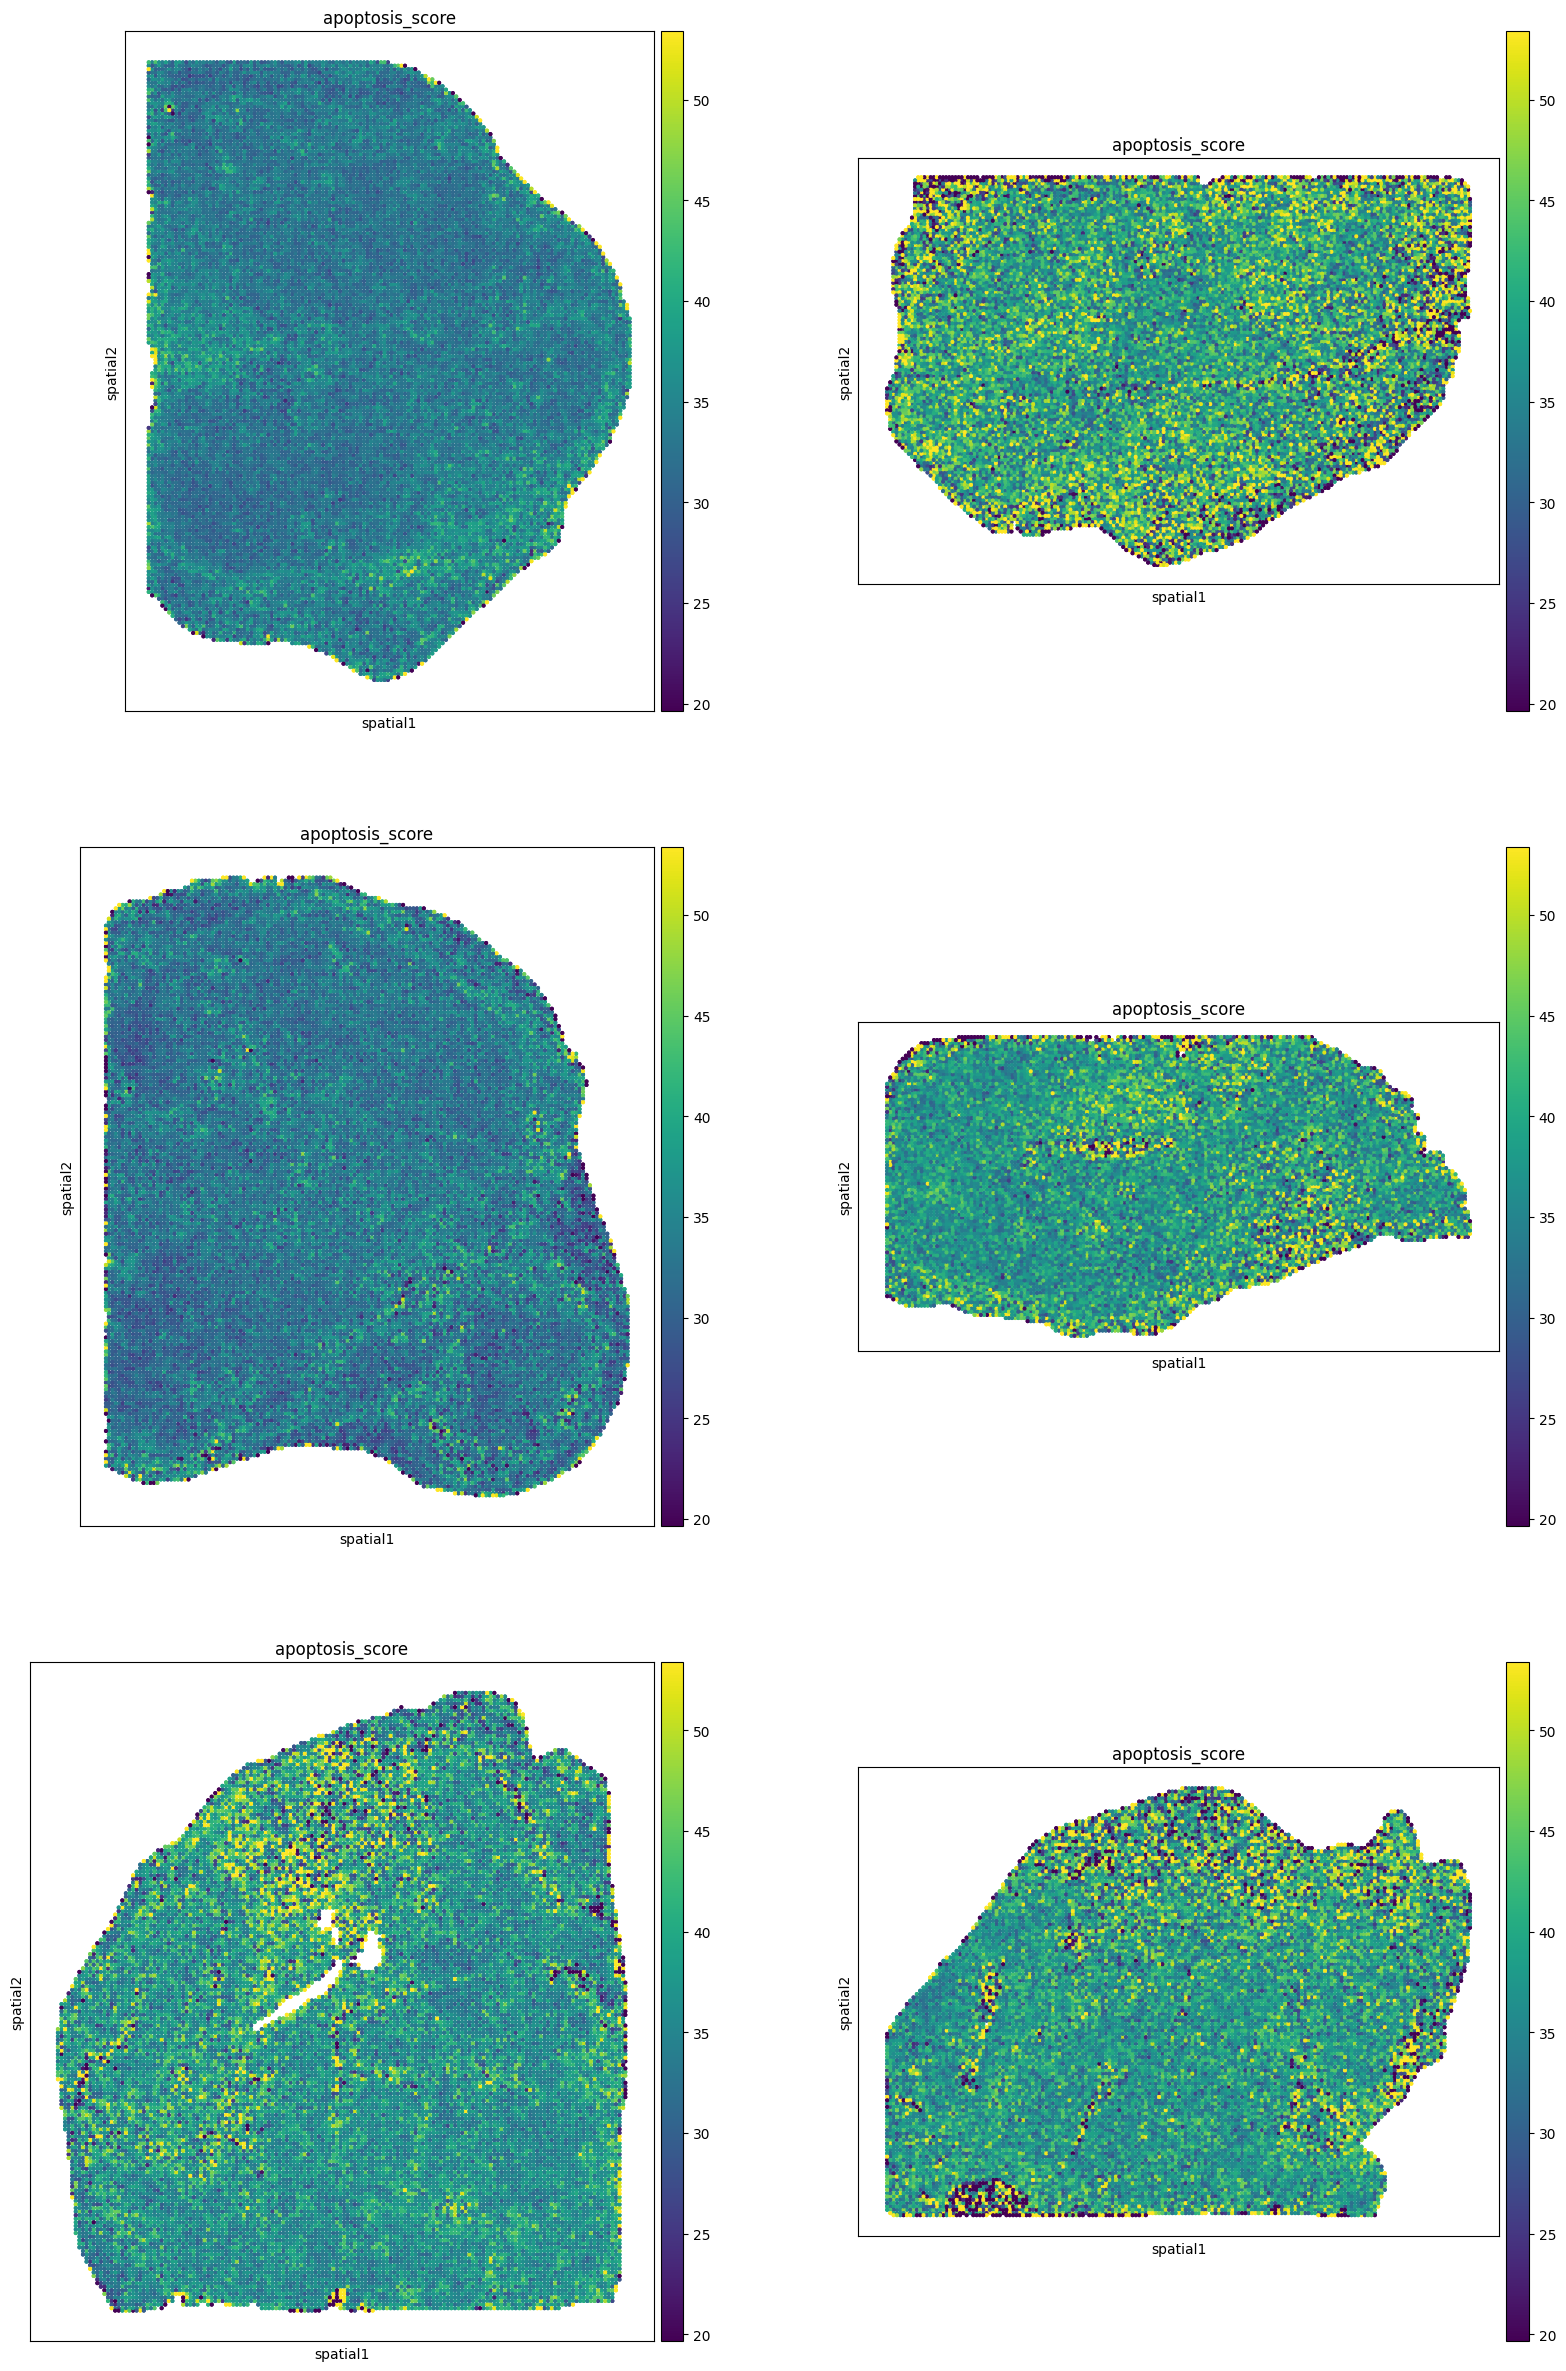

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(20, 30))
utils.plot_score(fdata, field="apoptosis_score", axs=axs, vmax=u + 2 * d, vmin=u - 2 * d, size=15)

# Correlation with T subtypes

In [15]:
T_marker = {
    "memory T": ["Il7r", "Cd27", "Timp1"],
    "effector T": ["Gzmk", "Gzma", "Gzmb", "Prf1", "Nkg7"],
    "exhausted T": ["Havcr2", "Lag3", "Entpd1", "Tigit", "Ctla4", "Layn"],
    "stem-like T": ["Tcf7", "Foxo1"]
}

In [16]:
for marker in T_marker:
    available_marker = np.intersect1d(T_marker[marker], fdata.var_names.tolist())
    fdata.obs[f"{marker}_score"] = fdata[:, available_marker].X.sum(axis=1)

In [17]:
r_dict = {}
for marker in T_marker:
    r, p = spearmanr(fdata.obs[f"{marker}_score"], fdata.obs["apoptosis_score"])
    r_dict[marker] = [r, p]
r_df = pd.DataFrame(r_dict, index=["spearmanr", "p-value"]).T

In [18]:
r_df

spearmanr        p-value
memory T      0.121422   0.000000e+00
effector T   -0.096119  9.824760e-241
exhausted T  -0.162607   0.000000e+00
stem-like T  -0.134578   0.000000e+00

In [19]:
r_dict = {}
p_dict = {}
for time_point in np.unique(fdata.obs["marker"]):
    fdata_ = fdata[fdata.obs["marker"] == time_point]
    r_dict[time_point] = []
    p_dict[time_point] = []
    for marker in T_marker:
        r, p = spearmanr(fdata_.obs[f"{marker}_score"], fdata_.obs["apoptosis_score"])
        r_dict[time_point].append(r)
        p_dict[time_point].append(p)
r_df = pd.DataFrame(r_dict, columns=np.unique(fdata.obs["marker"]), index=T_marker.keys()).T
p_df = pd.DataFrame(p_dict, columns=np.unique(fdata.obs["marker"]), index=T_marker.keys()).T

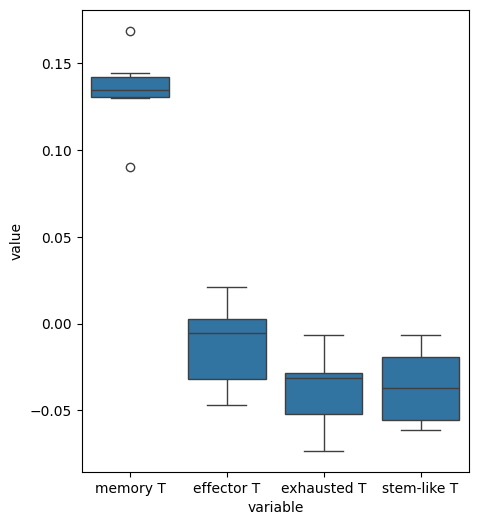

In [20]:
r_melt = r_df.melt()
plt.figure(figsize=(5, 6))
sns.boxplot(data=r_melt, x="variable", y="value")
plt.show()

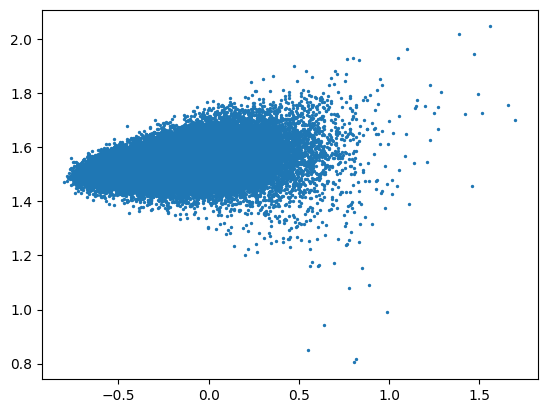

In [21]:
fdata_ = fdata[(fdata.obs["exhausted T_score"] > 0) & (fdata.obs["apoptosis_score"] > 0)]
plt.scatter(np.log10(fdata_.obs["exhausted T_score"]), np.log10(fdata_.obs["apoptosis_score"]), s=2)

In [22]:
import statsmodels.api as sm

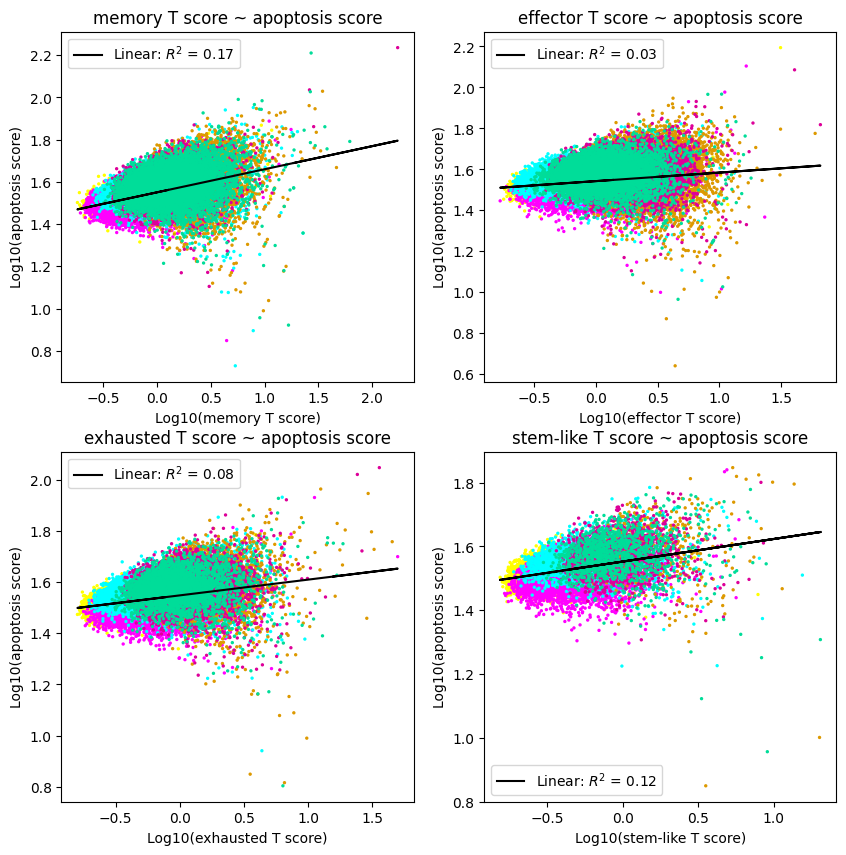

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
map_ = {
    '1-1': "#FFFF00",
    '1-2': "#DD9900",
    '2-1': "#FF00FF",
    '2-2': "#DD0099",
    '3-1': "#00FFFF",
    '3-2': "#00DD99"
}
for idx, marker in enumerate(T_marker):
    ax = axs[idx // 2, idx % 2]
    fdata_ = fdata[(fdata.obs[f"{marker}_score"] > 0) & (fdata.obs["apoptosis_score"] > 0)]
    x = np.log10(fdata_.obs[f"{marker}_score"])
    y = np.log10(fdata_.obs["apoptosis_score"])
    c = fdata_.obs["marker"]
    ax.scatter(x, y, s=2, c=c.map(map_))
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    intercept, slope = model.params
    r_squared = model.rsquared
    ax.plot(x, intercept + slope * x, color='black', label=f'Linear: $R^2$ = {r_squared:.2f}')

    ax.set_title(f"{marker} score ~ apoptosis score")
    ax.set_xlabel(f"Log10({marker} score)")
    ax.set_ylabel('Log10(apoptosis score)')
    ax.legend()
plt.show()

# T subtypes

In [24]:
fdata_bin20.obs["bin100"] = [str(marker) + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(fdata_bin20.obs["marker"], fdata_bin20.obsm["spatial"])]

In [25]:
c_df = fdata_bin20.obs[["annotations", "bin100"]].groupby("bin100").value_counts().unstack()

In [26]:
cc_df = c_df.loc[:, c_df.columns.str.endswith("T")]
cc_df

annotations    effector T  stem-like T  memory T  exhausted T  Unknown T
bin100                                                                  
1-1_0-0                 0            0         0            0          0
1-1_0-100               0            0         0            0          1
1-1_0-1000              1            0         0            0          1
1-1_0-10700             0            0         0            0          0
1-1_0-10800             1            0         0            0          0
...                   ...          ...       ...          ...        ...
3-2_9900-9500           0            0         0            0          1
3-2_9900-9600           0            0         0            0          1
3-2_9900-9700           0            0         0            0          1
3-2_9900-9800           1            0         0            0          0
3-2_9900-9900           0            0         0            0          1

[118279 rows x 5 columns]

In [27]:
fdata.obs["bin100"] = [str(marker) + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(fdata.obs["marker"], fdata.obsm["spatial"])]

In [28]:
dd_df = fdata.obs[["apoptosis_score", "bin100"]].sort_values(by="bin100").set_index("bin100")
dd_df = pd.concat([cc_df, dd_df], axis=1)

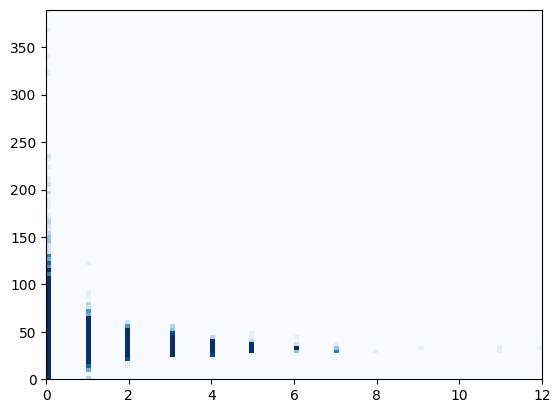

In [29]:
plt.hist2d(x=dd_df["effector T"], y=dd_df["apoptosis_score"], bins=100, vmax=10, cmap="Blues")
plt.show()

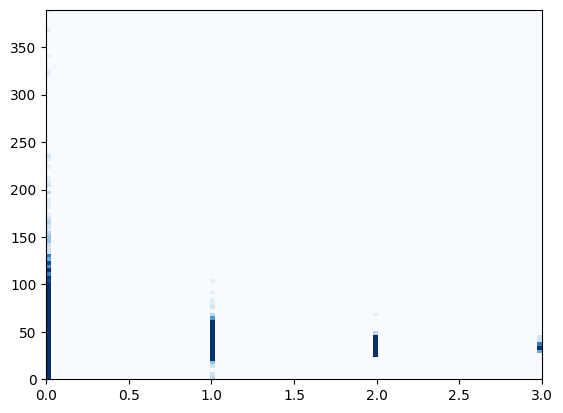

In [30]:
plt.hist2d(x=dd_df["exhausted T"], y=dd_df["apoptosis_score"], bins=100, vmax=10, cmap="Blues")
plt.show()

# Apoptosis with Guide

In [31]:
fdata_ = fdata[fdata.obs["marker"] == "2-1"]
cdata_ = cdata[cdata.obs["marker"] == "2-1"]

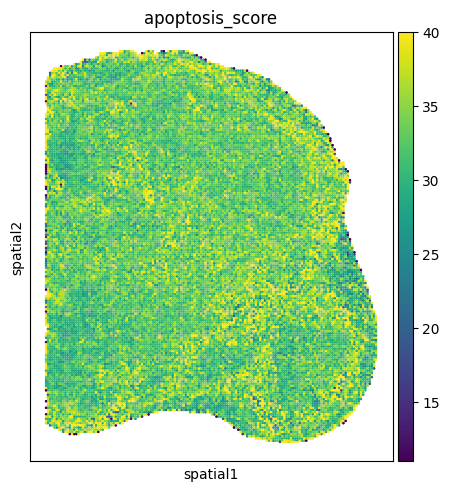

In [32]:
# plot globalf
sq.pl.spatial_scatter(fdata_, color="apoptosis_score", shape=None, size=2, library_id="spatial", vmax=40, vmin=11)

In [34]:
# guide proportion with apoptosis high and low

In [35]:
# t subtypes with guide
cdata_bin20 = sc.read_h5ad("./RNA/Multitime.annotation.guide.h5")

In [42]:
cdata_bin20.obs["annotations"] = fdata_bin20.obs["annotations"]

In [48]:
cdata_bin20 = utils.combine_guide_replicates(cdata_bin20)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [52]:
tdata_bin20 = cdata_bin20[fdata_bin20.obs["annotations"].str.endswith("T")]

In [56]:
tdata_bin20.X.toarray()

ArrayView([[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]])

In [69]:
c_df = pd.concat([pd.DataFrame(tdata_bin20.X.toarray(), index=tdata_bin20.obs_names), tdata_bin20.obs], axis=1)
c_df.columns = tdata_bin20.var_names.tolist() + ["marker", "cov", "annotations"]
c_df = c_df.groupby(["marker", "annotations"]).sum().iloc[:, :-1]

/tmp/ipykernel_16536/1974853160.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby(["marker", "annotations"]).sum().iloc[:, :-1]


In [73]:
c_df.reset_index(inplace=True)

In [82]:
df_long = pd.melt(c_df, id_vars=['marker', 'annotations'], var_name='guide', value_name='value')
df_long = df_long[df_long["annotations"] != "Unknown T"]
df_long["value"] = np.log10(df_long["value"])

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


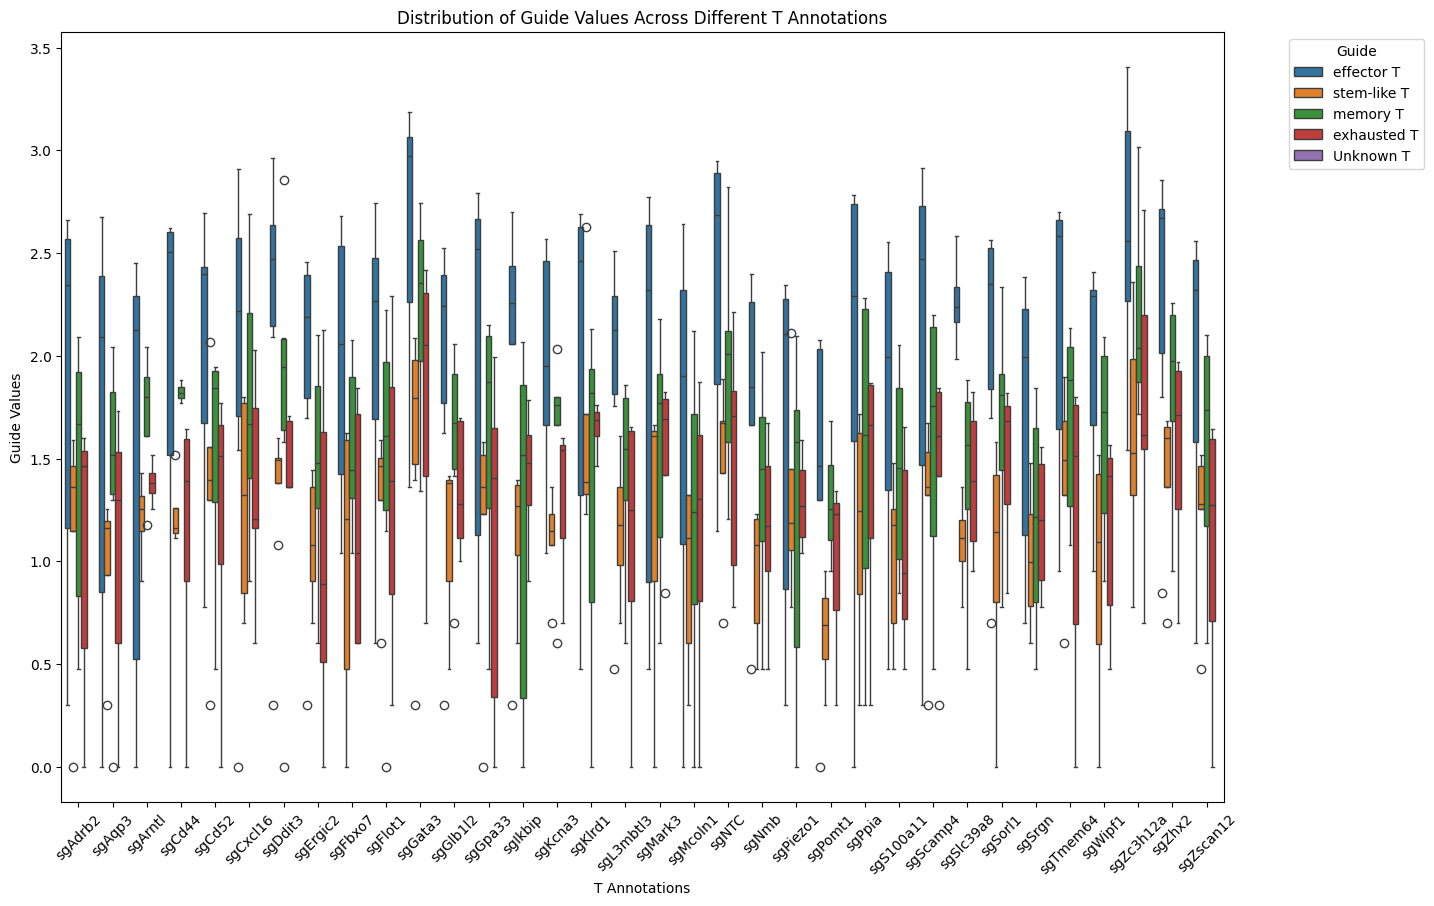

In [83]:
# 创建绘图
plt.figure(figsize=(15, 10))

# 使用 Seaborn 绘制箱型图
sns.boxplot(x='guide', y='value', hue='annotations', data=df_long)

# 设置图表标题和标签
plt.title('Distribution of Guide Values Across Different T Annotations')
plt.xlabel('T Annotations')
plt.ylabel('Guide Values')

# 显示图例
plt.legend(title='Guide', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 显示图表
plt.show()

In [86]:
cdata = utils.combine_guide_replicates(cdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [95]:
cdata.obs.groupby("marker").v

/tmp/ipykernel_16536/3807363833.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdata.obs.groupby("marker")


# Apoptosis Correlation at clone

/tmp/ipykernel_16536/3746480991.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  r_df = pd.DataFrame(fdata_.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: spearmanr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])
/tmp/ipykernel_16536/3746480991.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_df = pd.DataFrame(fdata_.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: spearmanr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])
/tmp/ipykernel_16536/37464809

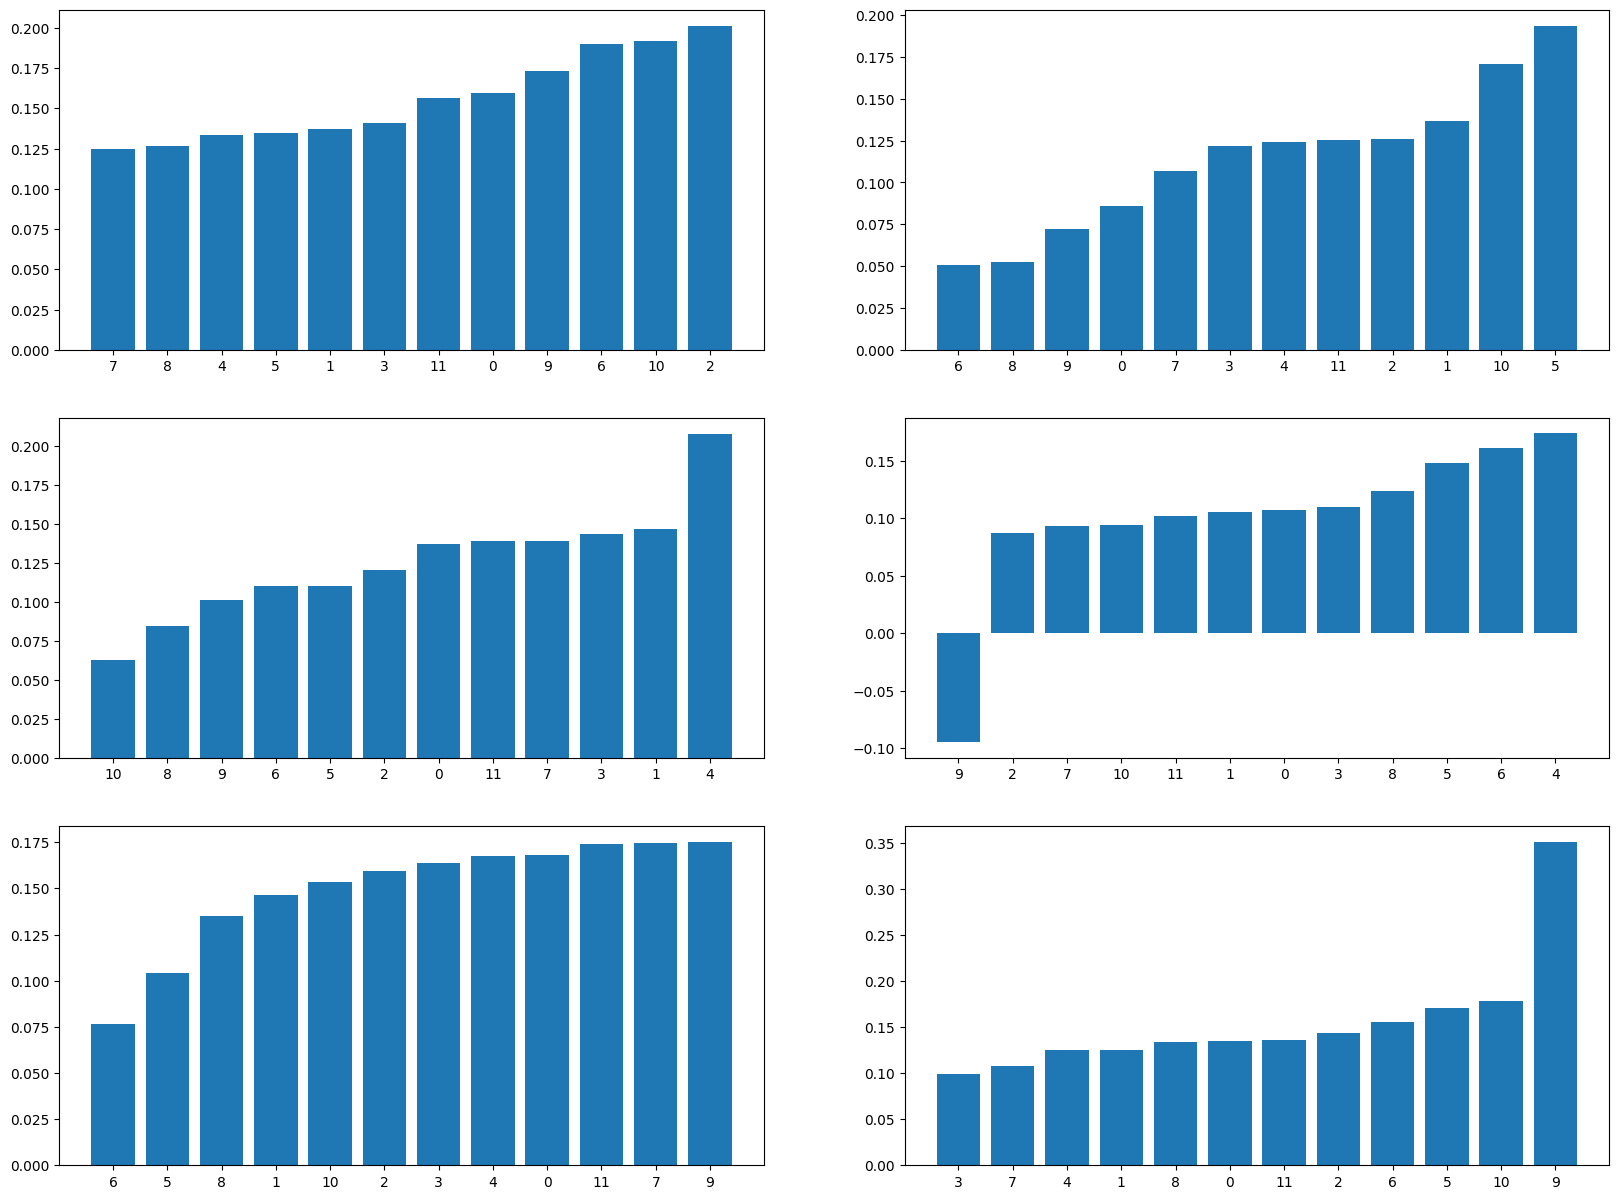

In [115]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
idx = 0
for marker in np.unique(fdata.obs["marker"]):
    ax = axs[idx // 2, idx % 2]
    fdata_ = fdata[fdata.obs["marker"] == marker].copy()
    r_df = pd.DataFrame(fdata_.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: spearmanr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])
    r_df.sort_values(inplace=True, by="r")
    ax.bar(r_df.index.astype(str), r_df.r)
    idx += 1

In [109]:
r_df = pd.DataFrame(fdata_.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: pearsonr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])

/tmp/ipykernel_16536/3146283406.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  r_df = pd.DataFrame(fdata_.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: pearsonr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])
/tmp/ipykernel_16536/3146283406.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_df = pd.DataFrame(fdata_.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: pearsonr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])


<BarContainer object of 12 artists>

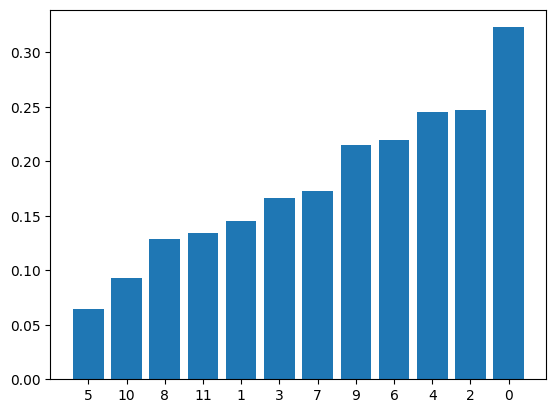

In [111]:
r_df.sort_values(inplace=True, by="r")
plt.bar(r_df.index.astype(str), r_df.r)

In [117]:
fdata, cdata = utils.align_rna_guide_data(fdata, cdata)

In [118]:
fdata_ = fdata[fdata.obs["marker"] == "2-1"].copy()

In [125]:
cdata_ = cdata[cdata.obs["marker"] == "2-1"].copy()

/tmp/ipykernel_16536/1128923340.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  r_df = pd.DataFrame(fdata__.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: spearmanr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])
/tmp/ipykernel_16536/1128923340.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_df = pd.DataFrame(fdata__.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: spearmanr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])
/tmp/ipykernel_16536/112892

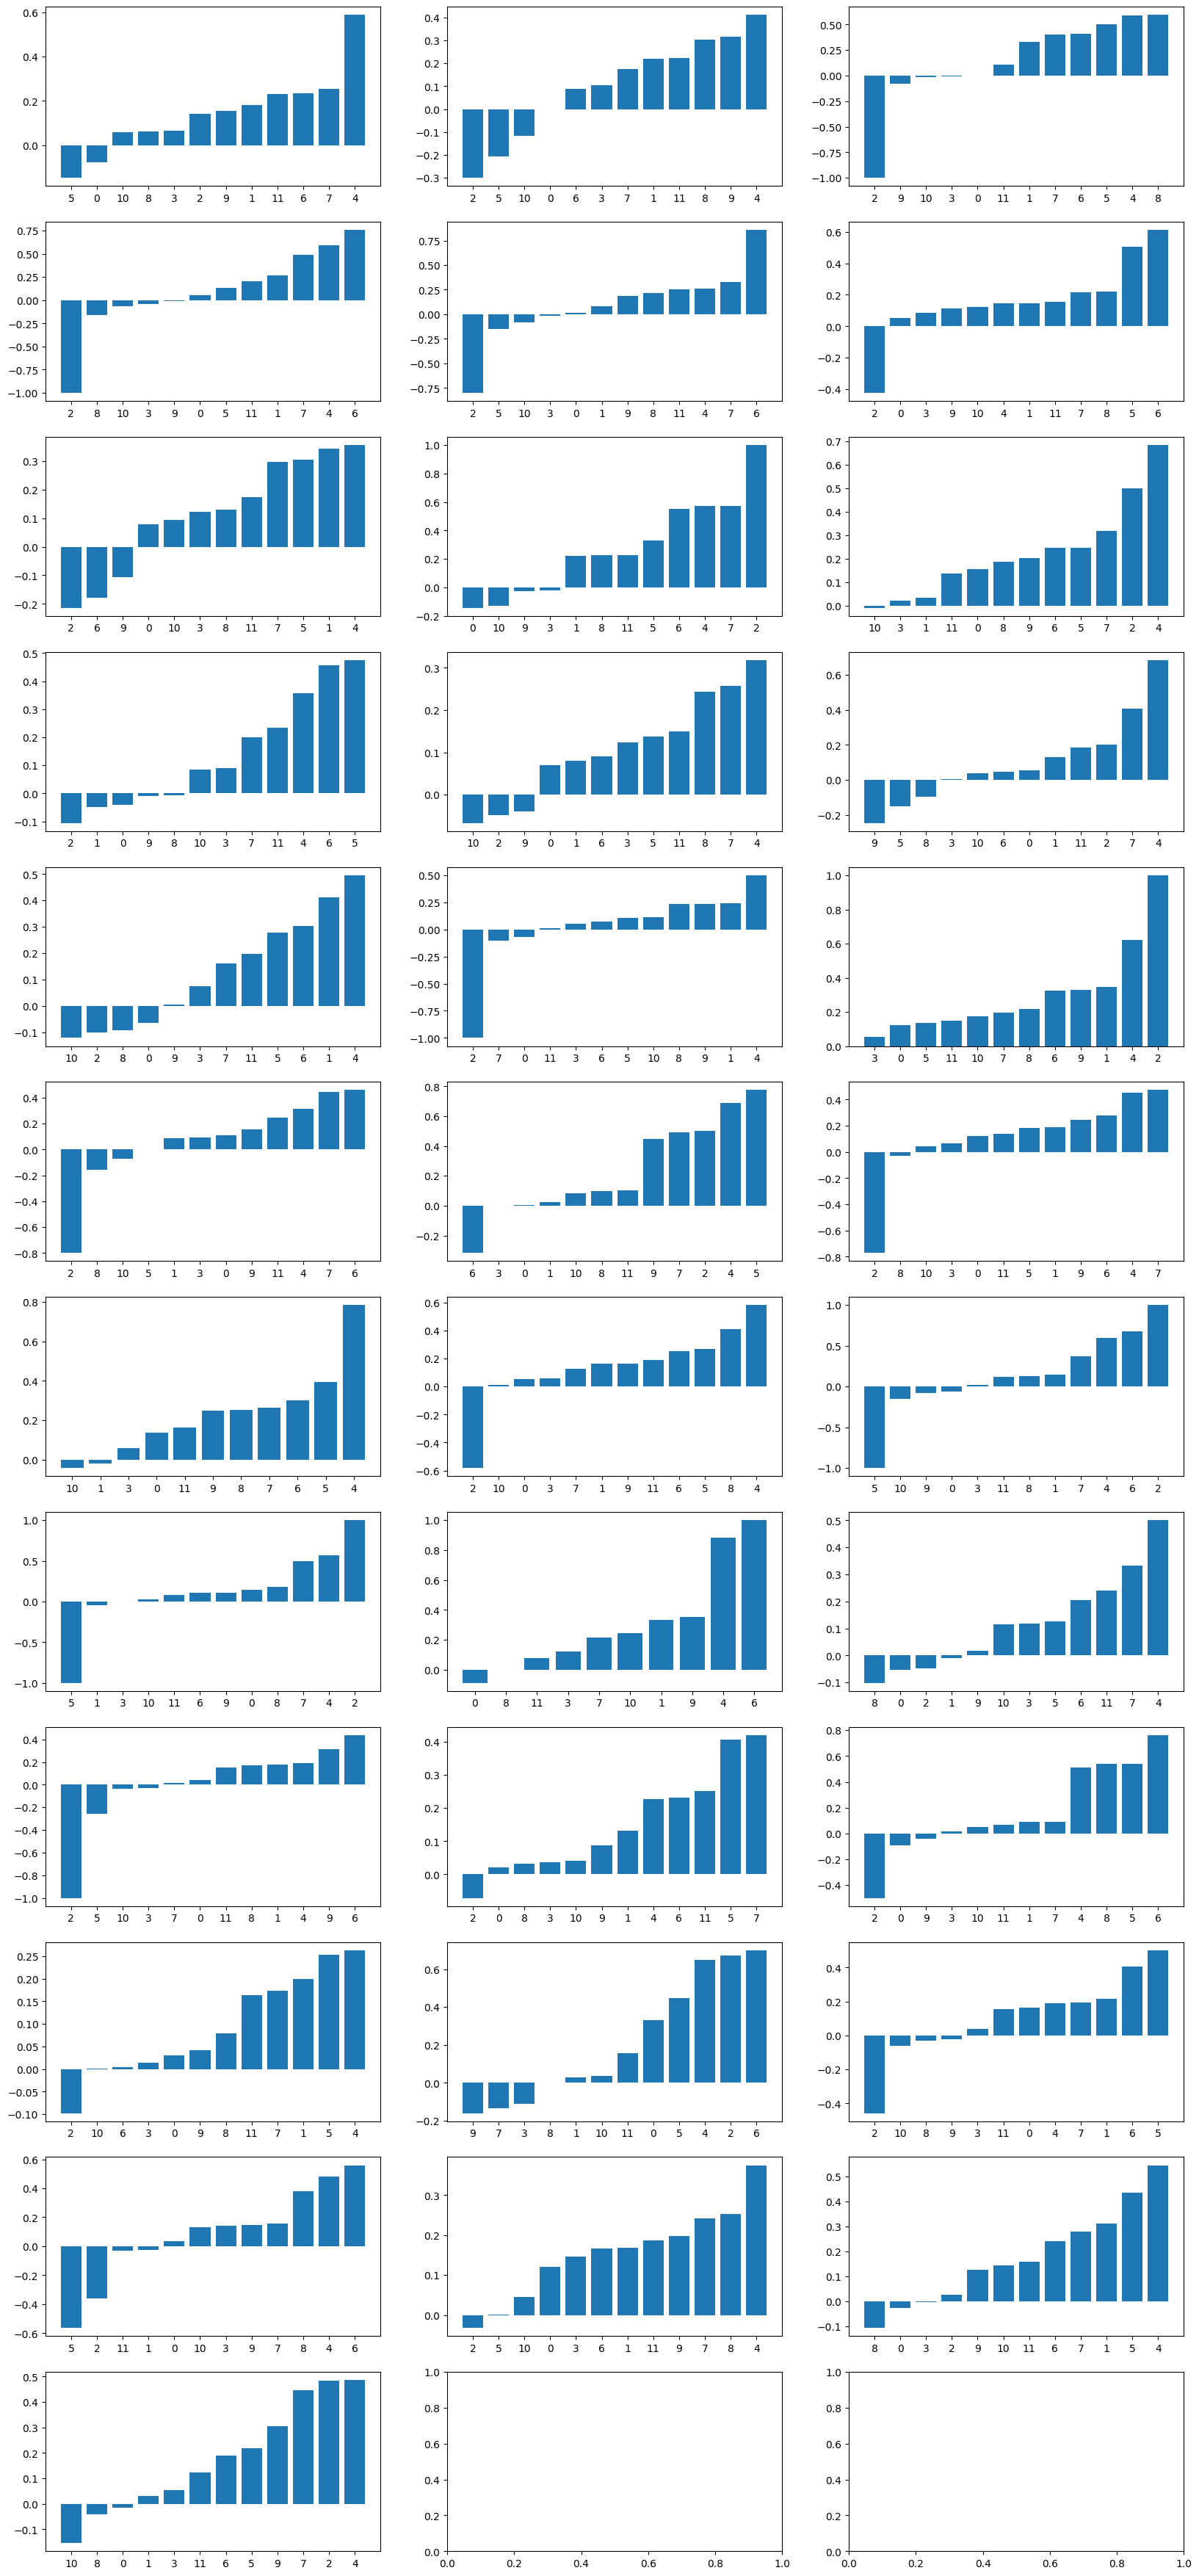

In [128]:
fig, axs = plt.subplots(12, 3, figsize=(20, 45))
idx = 0
for guide in cdata.var_names:
    ax = axs[idx // 3, idx % 3]
    fdata__ = fdata_[cdata_[:, guide].X.toarray() > 3].copy()
    r_df = pd.DataFrame(fdata__.obs.groupby("cluster_cellcharter_givenk").apply(lambda x: spearmanr(x["apoptosis_score"], x["memory T_score"])[0]), columns=["r"])
    r_df.sort_values(inplace=True, by="r")
    ax.bar(r_df.index.astype(str), r_df.r)
    idx += 1

/tmp/ipykernel_16536/3406735463.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(r_df.index, rotation=90)


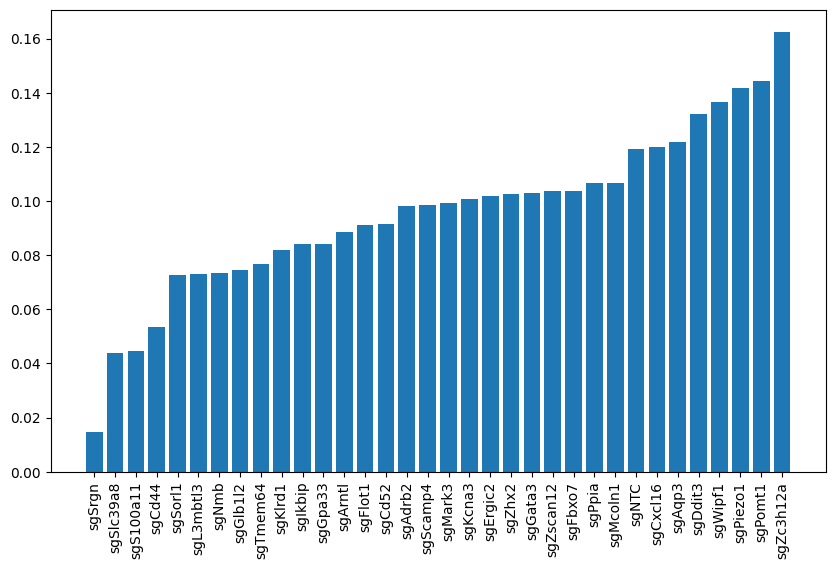

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
idx = 0
r_df = {}
for guide in cdata.var_names:
    fdata__ = fdata_[cdata_[:, guide].X.toarray() > 3].copy()
    r_df[guide] = spearmanr(fdata__.obs["apoptosis_score"], fdata__.obs["memory T_score"])[0]
r_df = pd.DataFrame(r_df, index=["r"]).T.sort_values(by="r")
ax.bar(r_df.index, r_df.r)
ax.set_xticklabels(r_df.index, rotation=90)
plt.show()

/tmp/ipykernel_16536/3195192923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(r_df.index, rotation=90)
/tmp/ipykernel_16536/3195192923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(r_df.index, rotation=90)
/tmp/ipykernel_16536/3195192923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(r_df.index, rotation=90)
/tmp/ipykernel_16536/3195192923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(r_df.index, rotation=90)
/tmp/ipykernel_16536/3195192923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usi

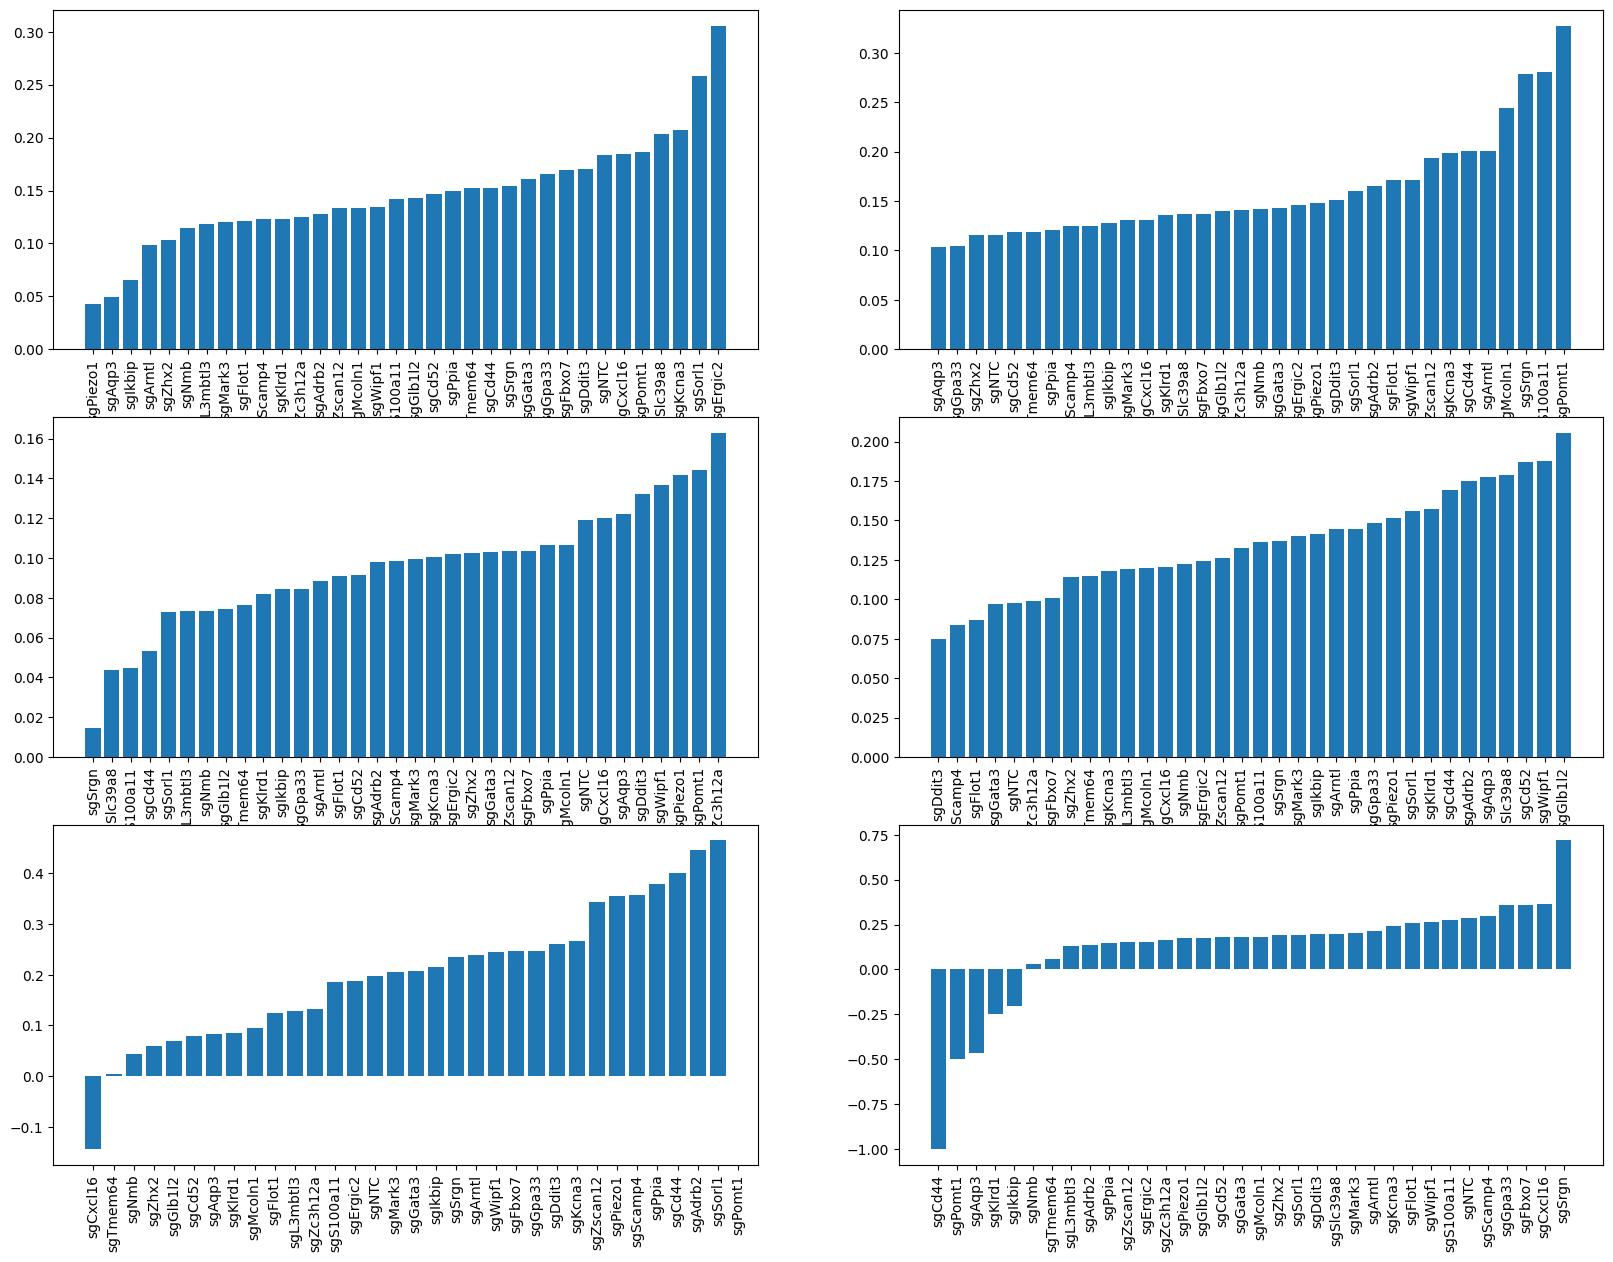

In [145]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
idx = 0
for marker in np.unique(fdata.obs["marker"]):
    ax = axs[idx // 2, idx % 2]
    r_df = {}
    fdata_ = fdata[fdata.obs["marker"] == marker].copy()
    cdata_ = cdata[cdata.obs["marker"] == marker].copy()
    for guide in cdata.var_names:
        fdata__ = fdata_[cdata_[:, guide].X.toarray() > 3].copy()
        r_df[guide] = spearmanr(fdata__.obs["apoptosis_score"], fdata__.obs["memory T_score"])[0]
    r_df = pd.DataFrame(r_df, index=["r"]).T.sort_values(by="r")
    ax.bar(r_df.index, r_df.r)
    ax.set_xticklabels(r_df.index, rotation=90)
    idx += 1
plt.show()

# Apoptosis High region

In [149]:
fdata_ = fdata[fdata.obs["marker"] == "2-1"].copy()
apoptosis_high_data = fdata_[fdata_.obs["apoptosis_score"] > np.quantile(fdata_.obs["apoptosis_score"], 0.75)]

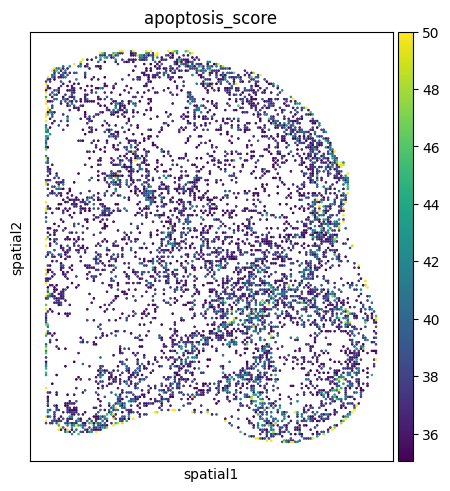

In [151]:
sq.pl.spatial_scatter(apoptosis_high_data, color="apoptosis_score", size=2, shape=None, library_id="spatial", vmax=50)

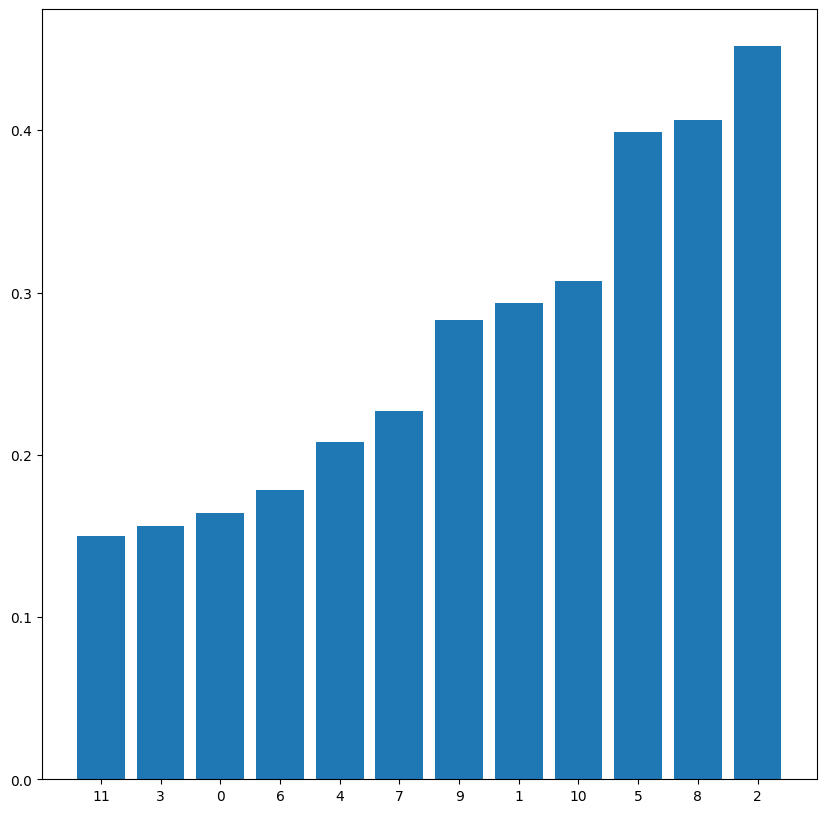

In [168]:
plt.figure(figsize=(10, 10))
df = pd.DataFrame(apoptosis_high_data.obs["cluster_cellcharter_givenk"].value_counts() / fdata_.obs["cluster_cellcharter_givenk"].value_counts())
df.sort_values(by="count", inplace=True)
plt.bar(x=df.index.astype(str), height=df["count"])
plt.show()

In [170]:
cdata_ = cdata[cdata.obs["marker"] == "2-1"].copy()
apoptosis_cdata = cdata_[fdata_.obs["apoptosis_score"] > np.quantile(fdata_.obs["apoptosis_score"], 0.75)]

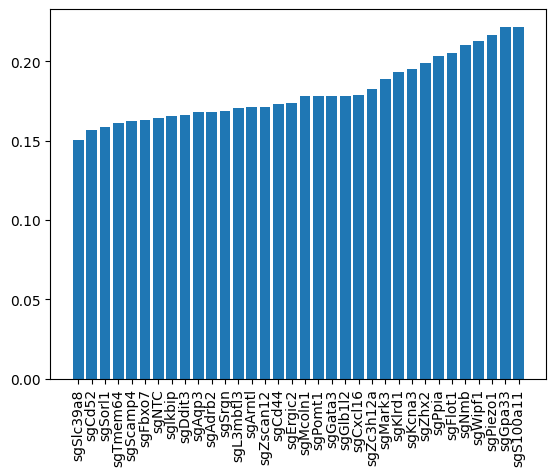

In [182]:
p_df = pd.DataFrame(apoptosis_cdata.X.sum(axis=0) / cdata_.X.sum(axis=0), index=cdata_.var_names)
p_df.sort_values(by=0, inplace=True)
plt.bar(p_df.index, p_df[0])
plt.xticks(rotation=90)
plt.show()